<a href="https://colab.research.google.com/github/sudohainguyen/STAN-small-tumor-aware-network/blob/master/examples/example_on_BUSI_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Sun Jun  7 16:06:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
os.chdir('/content/drive/My Drive/AI-projects/medical-image-segmentation/BUS')

# Import modules

In [0]:
import math
import cv2
import numpy as np
from PIL import Image

import tensorflow as tf

from tensorflow.keras.layers import (
    Conv2D, Dense, Flatten, Activation,
    InputLayer, BatchNormalization, 
    Concatenate, MaxPooling2D, Layer, Dropout,
    UpSampling2D, Conv2DTranspose, Input
) 
from tensorflow.keras.models import Model, load_model

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint,
    ReduceLROnPlateau, LearningRateScheduler
)
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, Iterator,
    load_img, img_to_array, random_shift
)
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.data import Dataset

from sklearn.model_selection import train_test_split, KFold

import matplotlib.pyplot as plt

# TPU config

In [0]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

# STAN Model implementation

### Blocks

In [0]:
def conv2D(n_filters, kernel_size, activation='relu', use_bn=False, **kwargs):
    def layer(x):
        x = Conv2D(n_filters, kernel_size, use_bias=(not use_bn),
                   padding='same', **kwargs)(x)
        if use_bn:
            x = BatchNormalization(x)
        x = Activation(activation)(x)
        return x
    return layer


def encoder_block(n_filters):
    def layer(inputs):
        kernel3_inp, kernelconcat_inp = inputs
        x1 = conv2D(n_filters, kernel_size=1)(kernelconcat_inp)
        x1 = conv2D(n_filters, kernel_size=1)(x1)

        x5 = conv2D(n_filters, kernel_size=5)(kernelconcat_inp)
        x5 = conv2D(n_filters, kernel_size=5)(x5)

        concat = tf.concat([x1, x5], axis=3)
        concat_pool = MaxPooling2D(pool_size=(2, 2))(concat)

        x3 = x3_1 = conv2D(n_filters * 2, kernel_size=3)(kernel3_inp)
        x3 = skip1 = conv2D(n_filters * 2, kernel_size=3)(x3)
        x3_pool = MaxPooling2D(pool_size=(2, 2))(x3)

        # skip2 = tf.concat([x3_1, concat], axis=3)
        skip2 = tf.add(x3_1, concat)
        return x3_pool, concat_pool, skip1, skip2
    return layer


def decoder_block(n_filters, use_bn=False, mode='transpose'):
    def layer(inputs):
        inp, skip1, skip2 = inputs
        if mode == 'transpose':
            x = Conv2DTranspose(n_filters, kernel_size=3,
                                 strides=(2,2), padding='same')(inp)
            if use_bn:
                x = BatchNormalization(x)
            x = tf.nn.relu(x)
        elif mode == 'upsampling':
            x = UpSampling2D(size=2)(inp)
        else:
            raise ValueError()
        
        concat = tf.concat([x, skip1], axis=3)
        x = conv2D(n_filters, kernel_size=3)(concat)
        concat = tf.concat([x, skip2], axis=3)
        x = conv2D(n_filters, kernel_size=3)(concat)
        return x
    return layer

### Builder Functions

In [0]:
def build_stan(
    n_classes,
    input_shape=(None, None, 3),
    filters=[32, 64, 128, 256, 512],
    decode_mode='transpose',
    activation='sigmoid'
):
    """Pure STAN builder using Conv blocks (no backbone)

    Arguments:
        n_classes {int} -- Number of classes

    Keyword Arguments:
        input_shape {tuple} -- The shape of input (default: {(256, 256, 3)})
        filters {list} -- Declare number of filters for each encoding block
        (default: {[32, 64, 128, 256, 512]})
        activation {str} -- activation function of the last layer before giving prediction
    """
    inp = Input(shape=input_shape)

    # Encoder
    x3_pool, concat_pool, skip1_b1, skip2_b1 = encoder_block(filters[0])((inp, inp))
#     skip2_b1 = tf.concat([x3_1, concat_out], axis=3)
    
    x3_pool, concat_pool, skip1_b2, skip2_b2 = encoder_block(filters[1])((x3_pool, concat_pool))
#     skip2_b2 = tf.concat([x3_1, concat_out], axis=3)
    
    x3_pool, concat_pool, skip1_b3, skip2_b3 = encoder_block(filters[2])((x3_pool, concat_pool))
#     skip2_b3 = tf.concat([x3_1, concat_out], axis=3)
    
    x3_pool, concat_pool, skip1_b4, skip2_b4 = encoder_block(filters[3])((x3_pool, concat_pool))
#     skip2_b4 = tf.concat([x3_1, concat_out], axis=3)
    
    # middle
    x3_pool         = conv2D(n_filters=filters[4], kernel_size=3)(x3_pool)
    x3_pool         = conv2D(n_filters=filters[4], kernel_size=3)(x3_pool)
    concat_pool_1   = conv2D(n_filters=filters[4], kernel_size=1)(concat_pool)
    concat_pool_1   = conv2D(n_filters=filters[4], kernel_size=3)(concat_pool_1)
    concat_pool_5   = conv2D(n_filters=filters[4], kernel_size=5)(concat_pool)
    concat_pool_5   = conv2D(n_filters=filters[4], kernel_size=3)(concat_pool_5)

    mid = tf.concat([x3_pool, concat_pool_1, concat_pool_5], axis=3, name='encoded_fm_concat')

    # Decoder
    x = decoder_block(n_filters=filters[3], mode=decode_mode)((mid, skip1_b4, skip2_b4))
    x = decoder_block(n_filters=filters[2], mode=decode_mode)((x, skip1_b3, skip2_b3))
    x = decoder_block(n_filters=filters[1], mode=decode_mode)((x, skip1_b2, skip2_b2))
    x = decoder_block(n_filters=filters[0], mode=decode_mode)((x, skip1_b1, skip2_b1))

    # Last conv layer
    x = conv2D(n_filters=n_classes, kernel_size=3, activation=activation)(x)

    return Model(inp, x)

def freeze_model(model):
    for layer in model.layers:
        layer.trainable = True

def STAN(
    n_classes, 
    input_shape=(None, None, 3),
    filters=[32, 64, 128, 256, 512],
    encoder_weights=None,
    output_activation='sigmoid',
    decode_mode='transpose',
    freeze_encoder=False,
    model_name='stan'
):
    """[summary]

    Arguments:
        n_classes {[type]} -- Number of classes for segmentation

    Keyword Arguments:
        input_shape {tuple} -- Shape of input tesors (default: {(256, 256, 3)})
        encoder_weights {[type]} -- pretrained weights path for encoder (default: {None})
        output_activation {str} -- Activation function for output prediction (default: {'sigmoid'})
        decode_mode {str} -- Mode for decoder, could be Transpose or Upsampling (default: {'transpose'})
        freeze_encoder {bool} -- Freezing encoder for fine-tuning (default: {False})
    """    
    model = build_stan(
        n_classes=n_classes,
        input_shape=input_shape,
        filters=filters,
        activation=output_activation,
        decode_mode=decode_mode)
    
    if freeze_encoder:
        freeze_model(model)
    
    # TODO: able to load pre-trained weights to encoder
    
    # model.name = model_name

    return model

## Plot model

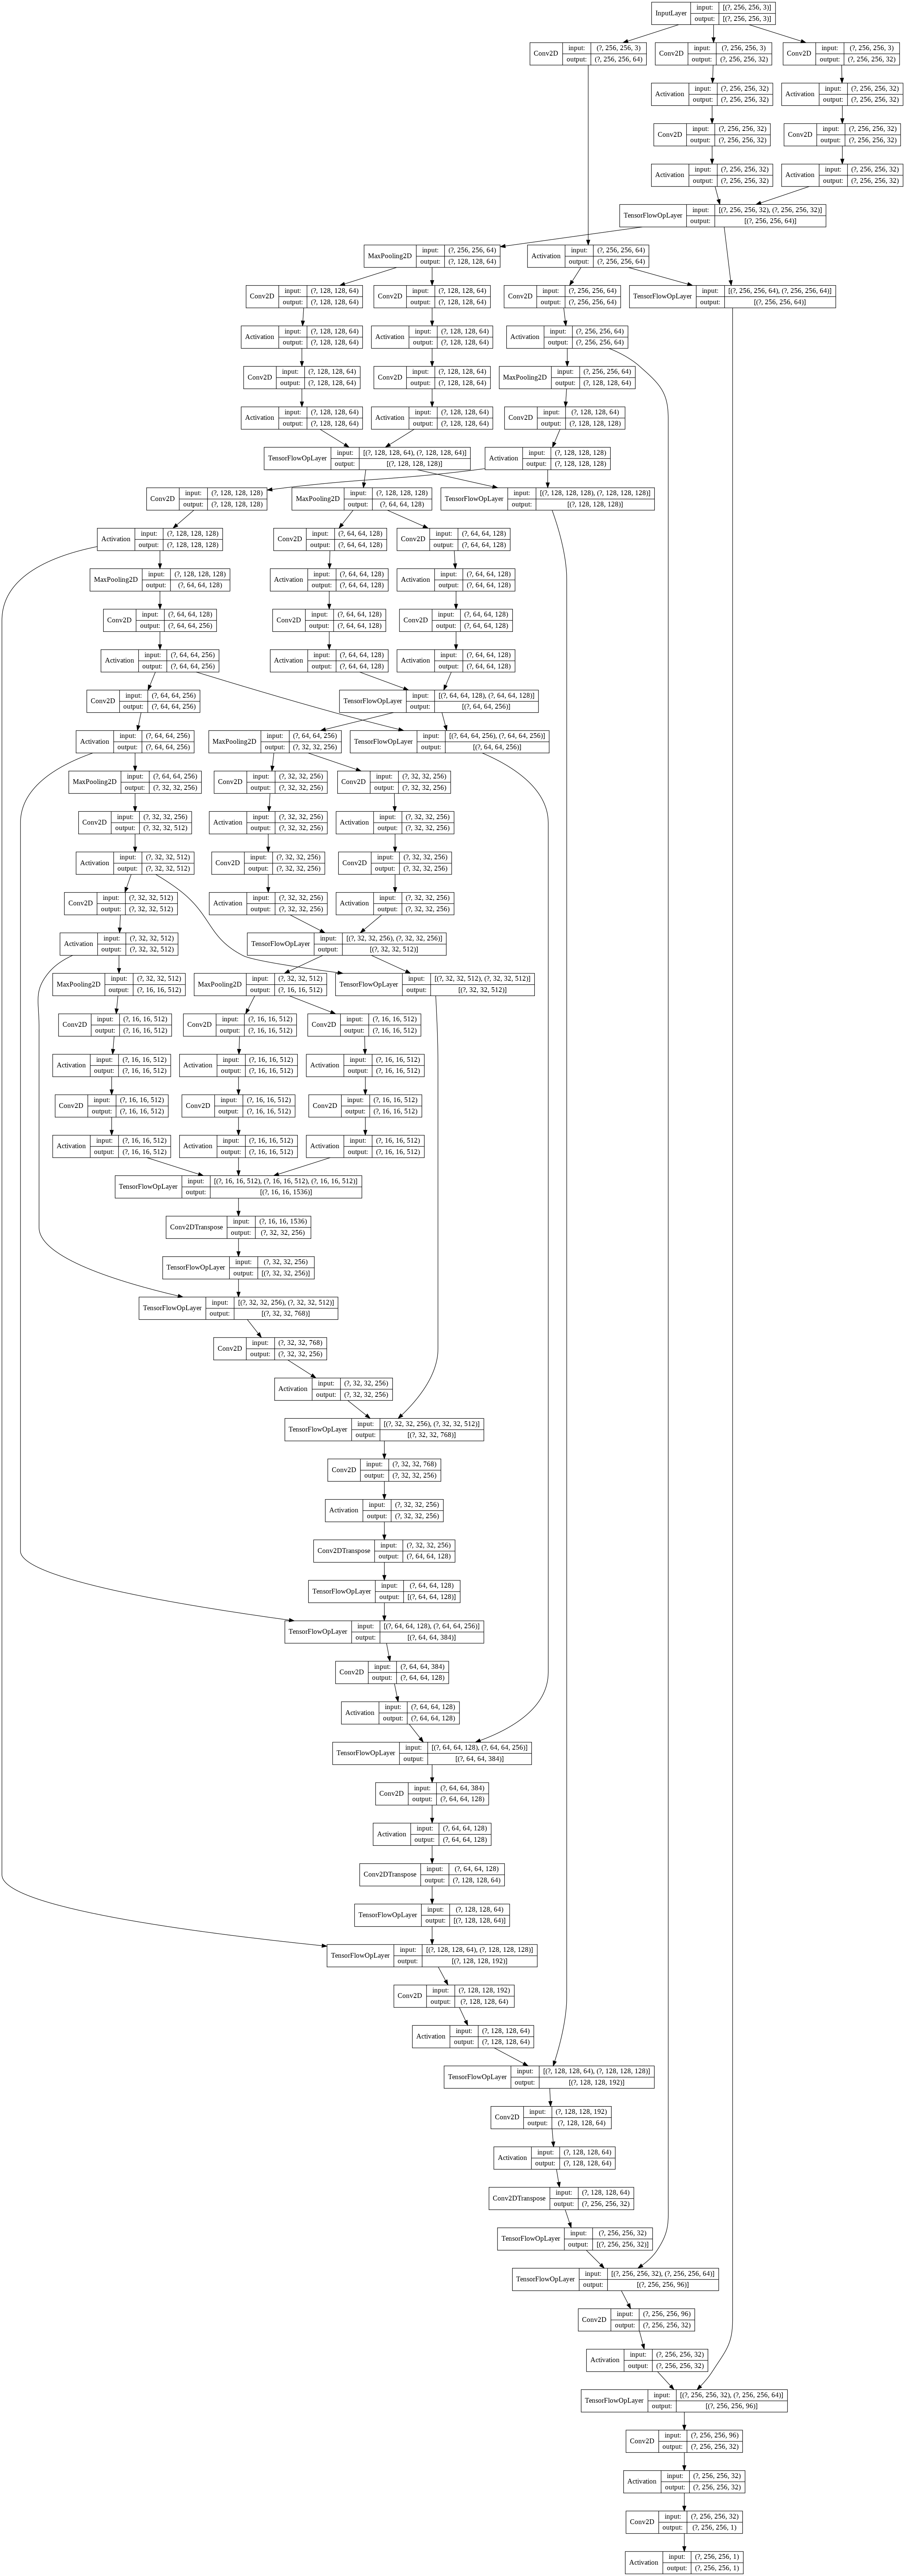

In [0]:
model = STAN(1, input_shape=(256,256,3), decode_mode='transpose')
plot_model(model, show_shapes=True, to_file='functional.png',
           show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96)

# BUSI dataset

In [0]:
fnames = np.array([os.path.splitext(f)[0] for f in os.listdir('./images')])

In [0]:
np.random.seed(101)
np.random.shuffle(fnames)
print(fnames.shape)

(163,)


# Helpers

In [0]:
def build_lrfn(lr_start=0.00001, lr_max=0.0001, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn 

# Training on BUSI dataset

## Metrics

In [0]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def true_pos(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def true_neg(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn

def false_pos(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
    fp_ratio = (K.sum(y_neg * y_pred_pos) + smooth) / (K.sum(y_neg) + smooth)
    return fp_ratio

## Loss functions


#### Common

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

#### Tversky

In [0]:
def _tversky_index(y_true, y_pred, smooth=1.0, alpha=0.5):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    fp = K.sum((1 - y_true) * y_pred)
    
    return (tp + smooth) / (tp + alpha * fn + (1 - alpha) * fp + smooth)


def tversky_loss(smooth_tversky=1.0, alpha=0.5):
    def compute_loss(y_true, y_pred):
        return 1 - _tversky_index(y_true, y_pred,
                                  smooth=smooth_tversky, alpha=alpha)
    return compute_loss


def focal_tversky_loss(gamma=0.75, smooth_tversky=1.0, alpha=0.5):
    def compute_loss(y_true, y_pred):
        pt_1 = _tversky_index(y_true, y_pred,
                              smooth=smooth_tversky, alpha=alpha)
        return K.pow((1 - pt_1), 1 / gamma)
    return compute_loss

#### Lovasz Loss

In [0]:
def lovasz_grad(gt_sorted):
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


def lovasz_hinge_flat(y_true, y_pred):
    def compute_loss():
        labelsf = tf.cast(y_true, y_pred.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - y_pred * tf.stop_gradient(signs)
        error_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0])
        
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(error_sorted), 
                            tf.stop_gradient(grad), 1)
        return loss
    
    loss = tf.cond(tf.equal(tf.shape(y_pred)[0], 0),
                   lambda: tf.reduce_sum(y_pred) * 0.,
                   compute_loss)
    return loss


def lovasz_hinge(per_image=False, ignore=None):
    """ Binary Lovasz hinge loss

    Parameters
    ----------
    y_true : [B, H, W] Variable
        logits at each pixel
    y_pred : [type]
        [description]
    per_image : bool, optional
        [description], by default True
    ignore : [type], optional
        [description], by default None
    """
    def inner(y_true, y_pred):
        if per_image:
            def treat_image(log_lab):
                log, lab = log_lab
                log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
                log, lab = flatten_binary_scores(log, lab, ignore)
                return lovasz_hinge_flat(log, lab)
            losses = tf.map_fn(treat_image, (y_pred, y_true), dtype=tf.float32)
            loss = tf.reduce_mean(losses)
        else:
            loss = lovasz_hinge_flat(
                *flatten_binary_scores(y_pred, y_true, ignore))
        return loss
    return inner


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

#### Bending Loss

In [0]:
import math
def cal_magnitude(vector):
    return np.linalg.norm(vector)

def cal_curvature(v1, v2):
    # calculate curvature between 2 vectors
    return 2 * cal_magnitude(np.multiply(v1, v2)) / (cal_magnitude(v1) * cal_magnitude(v2) + np.dot(v1, v2))

@tf.function
def bending(masks):
    loss_on_batch = 0
    for mask in masks:
        contours, _ = cv2.findContours(cv2.UMat(mask),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        contours = contours[0].reshape(-1, 2)
        losses = 0
        total_points = len(contours)
        for i in range(total_points):
            v1 = contours[i] - contours[i - 1]
            if i == total_points - 1:
                v2 = contours[0] - contours[i]
            else:
                v2 = contours[i + 1] - contours[i]
            
            curvature = cal_curvature(v1, v2)
            losses += math.pow(curvature, 2) / (cal_magnitude(v1) + cal_magnitude(v2))
        loss_on_batch += losses / total_points
    return loss_on_batch / masks.shape[0]

def bending_loss(base_loss_name='dice', alpha=0.3):
    def inner(y_true, y_pred):
        base_loss = get_loss_by_name(base_loss_name)
        return base_loss(y_true, y_pred) + alpha * bending(y_pred)
    return inner

In [0]:
def get_loss_by_name(name, **kwargs):
    if name == 'tversky':
        # alpha
        
        return tversky_loss(alpha=0.3)
    elif name == 'focal_tversky':
        return focal_tversky_loss(gamma=3, smooth_tversky=1.0, alpha=0.3)
    elif name == 'dice':
        return dice_loss
    elif name == 'bce_dice':
        return bce_dice_loss
    elif name == 'lovasz':
        return lovasz_hinge(per_image=False, ignore=None)
    else:
        raise NotImplementedError

## Generators


### Base Gen

In [0]:
class BaseGenerator(Iterator):
    def __init__(
        self,
        fnames,
        data_dir='.',
        n_classes=1,
        resized_shape=(256, 256),
        batch_size=8,
        shuffle=False,
        seed=None,
        **kwargs
    ):
        """Generator initialization, inherits Iterator class

        Arguments:
            fnames {list} -- List of filenames from dataset (not including extension part)

        Keyword Arguments:
            data_dir {str} -- The main dataset directory (default: {'.'})
            n_classes {int} -- Number of classes (default: {1})
            resized_shape {tuple} -- All images are reshaped to this size (default: {(256, 256)})
            batch_size {int} -- Batch size (default: {8})
            shuffle {bool} -- (default: {False})
        """
        self.fnames = fnames
        self.data_dir = data_dir
        self.seed = seed
        self.ids = np.array(range(len(fnames)))
        self.n_samples = len(self.ids)
        self.resized_shape = resized_shape
        
        self.shuffle = shuffle
        self.batch_size = batch_size

        # self.img_gen = ImageDataGenerator(**kwargs)
        # self.msk_gen = ImageDataGenerator(**kwargs)
        tf.random.set_seed(self.seed)

    def __len__(self):
        return math.ceil(self.n_samples / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.ids)

    def __getitem__(self, idx):
        indices = self.ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        imgs, msks = self._read_data(indices)
        imgs, msks = self._preprocessing(imgs, msks)
        
        imgs = tf.convert_to_tensor(imgs, dtype=tf.float32)
        msks = tf.convert_to_tensor(msks, dtype=tf.float32)
        return imgs, msks
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item

    def _norm(self, tensor, mode='tf'):
        raise NotImplementedError

    def _preprocessing(self, imgs, msks=None):
        raise NotImplementedError

    def _read_data(self, ids):
        raise NotImplementedError

### Dataset B Gen

In [0]:
class BUSIGenerator(BaseGenerator):
    def __init__(self, fnames, input_channel=3, norm_mode='none', **kwargs):
        super(BUSIGenerator, self).__init__(fnames, **kwargs)
        self.input_channel = input_channel
        self.norm_mode = norm_mode

    def _read_data(self, ids):
        imgs = np.empty((self.batch_size, self.resized_shape[0],
                        self.resized_shape[1], self.input_channel))
        msks = np.empty((self.batch_size, self.resized_shape[0], self.resized_shape[1], 1))
        for i, index in enumerate(ids):
            file_name = self.fnames[index]
            read_im_mode = 'rgb'
            if self.input_channel == 1:
                read_im_mode = 'grayscale'
            # img = cv2.imread(os.path.join(self.data_dir, 'images', f'{file_name}.png'), read_im_mode)
            # msk = cv2.imread(os.path.join(self.data_dir, 'masks', f'{file_name}.png'), 0)
            img = load_img(os.path.join(self.data_dir, 'images', f'{file_name}.png'), 
                           color_mode=read_im_mode, target_size=self.resized_shape)
            msk = load_img(os.path.join(self.data_dir, 'masks', f'{file_name}.png'),
                           color_mode='grayscale', target_size=self.resized_shape)
            img = img_to_array(img)
            msk = img_to_array(msk)
            
            # if self.resized_shape:
                # img = cv2.resize(img, self.resized_shape)
                # msk = cv2.resize(msk, self.resized_shape)

            if self.input_channel == 1:
                img = K.expand_dims(img, axis=2)
            imgs[i] = img
            msks[i] = msk
            # msks[i] = K.expand_dims(msk, axis=2)
        return imgs, msks

    def _norm(self, tensor, mode='tf'):
        if mode == 'tf':
            tensor /= 127.5
            tensor -= 1.
        elif mode == 'caffe':
            tensor[..., 0] -= 103.939
            tensor[..., 1] -= 116.779
            tensor[..., 2] -= 123.68
        elif mode == 'minmax':
            tensor_min = K.min(tensor)
            tensor_max = K.max(tensor)
            tensor = (tensor - tensor_min) / (tensor_max - tensor_min)
        elif mode == 'z_score':
            tensor = (tensor - K.mean(tensor)) / K.std(tensor)
        elif mode == 'max':
            tensor /= 255
        elif mode == 'none':
            pass
        else:
            raise NotImplementedError
        return tensor

    def _preprocessing(self, imgs, msks=None):

        imgs = self._norm(imgs, mode=self.norm_mode)
        # imgs = tf.map_fn(lambda img: tf.image.random_flip_left_right(img, seed=self.seed), imgs)
        # imgs = tf.map_fn(lambda img: random_shift(img, 0.08, 0.05, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest'), imgs)
        # imgs = self.img_gen.flow(imgs, seed=self.seed)
        # imgs = next(imgs)
        if msks is None:
            return imgs
        msks = self._norm(msks, mode='max')
        # msks = tf.map_fn(lambda msk: tf.image.random_flip_left_right(msk, seed=self.seed), msks)
        # msks = tf.map_fn(lambda msk: random_shift(msk, 0.08, 0.05, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest'), msks)
        # msks = K.clip(msks, 0, 1)
        # msks = self.msk_gen.flow(msks, seed=self.seed)
        # msks = next(msks)
        return imgs, msks

## Callbacks

In [0]:
lr_scheduler = LearningRateScheduler(build_lrfn(lr_start=0.00005, lr_max=0.0001, 
                                     lr_min=0.000001, lr_rampup_epochs=12, 
                                     lr_sustain_epochs=0, lr_exp_decay=.8),
                                     verbose=1)
def get_callbacks(fold, model_name):
    return [
        ModelCheckpoint(f'{model_name}_fold{fold}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=15),
        # lr_scheduler
        ReduceLROnPlateau(monitor='val_loss', patience=4)
    ]

## Training

In [0]:
num_folds = 5
BATCH_SIZE = 32
input_shape = (256, 256, 3)
loss_name = 'dice'

kfold = KFold(n_splits=num_folds)

In [0]:
hists = []
with strategy.scope():
    for i, (train, test) in enumerate(kfold.split(fnames)):
        print(f'\n======================== Fold {i} ========================\n')

        criterion = get_loss_by_name(loss_name)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

        train_gen = BUSIGenerator(fnames[train], batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                                resized_shape=(input_shape[0], input_shape[1]), 
                                norm_mode='max', seed=10, shuffle=True,
                                width_shift_range=0.08, height_shift_range=0.05)

        val_gen = BUSIGenerator(fnames[test], batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                                resized_shape=(input_shape[0], input_shape[1]),
                                norm_mode='max', seed=10, shuffle=False,
                                width_shift_range=0.08, height_shift_range=0.05)

        model = STAN(1, input_shape=input_shape, 
                     filters=[32, 64, 128, 256, 512], decode_mode='transpose')
        model.compile(optimizer=optimizer, loss=criterion, metrics=[dice_coef])

        history = model.fit(x=train_gen, epochs=200, batch_size=BATCH_SIZE,
                            callbacks=get_callbacks(i, model_name=f'model_add_{loss_name}'),
                            validation_data=val_gen, verbose=2)
        hists.append(history)


======================== Fold 0 ========================

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.95423, saving model to model_add_dice_fold0.h5
5/5 - 9s - loss: 0.9281 - dice_coef: 0.0719 - val_loss: 0.9542 - val_dice_coef: 0.0458 - lr: 1.0000e-04
Epoch 2/200

Epoch 00002: val_loss improved from 0.95423 to 0.95374, saving model to model_add_dice_fold0.h5
5/5 - 6s - loss: 0.9269 - dice_coef: 0.0731 - val_loss: 0.9537 - val_dice_coef: 0.0463 - lr: 1.0000e-04
Epoch 3/200

Epoch 00003: val_loss improved from 0.95374 to 0.95306, saving model to model_add_dice_fold0.h5
5/5 - 6s - loss: 0.9258 - dice_coef: 0.0742 - val_loss: 0.9531 - val_dice_coef: 0.0469 - lr: 1.0000e-04
Epoch 4/200

Epoch 00004: val_loss improved from 0.95306 to 0.95228, saving model to model_add_dice_fold0.h5
5/5 - 6s - loss: 0.9247 - dice_coef: 0.0753 - val_loss: 0.9523 - val_dice_coef: 0.0477 - lr: 1.0000e-04
Epoch 5/200

Epoch 00005: val_loss improved from 0.95228 to 0.95074, saving model to model_ad

In [0]:
for i, history in enumerate(hists):
    _, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(history.history['dice_coef'])
    ax[0].plot(history.history['val_dice_coef'])
    ax[0].set_title(f'model dice score - FOLD {i + 1}')
    ax[0].set_ylabel('dice score')
    ax[0].set_xlabel('epoch')
    # ax[0].legend(['train', 'val'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title(f'model loss - FOLD {i + 1}')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper right')

plt.show()

## Evaluation

### Dice

In [0]:
avg_loss, avg_dice, avg_tp, avg_fp = 0, 0, 0, 0
kf = KFold(n_splits=num_folds)
criterion = get_loss_by_name(loss_name)
for i, (_, test) in enumerate(kf.split(fnames)):
    test_gen = BUSIGenerator(fnames[test], batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                             resized_shape=(input_shape[0], input_shape[1]),
                             norm_mode='max', seed=10)

    model = STAN(1, input_shape=input_shape, 
                 filters=[32, 64, 128, 256], decode_mode='transpose')
    model.load_weights(f'model_add_{loss_name}_fold{i}.h5')
    model.compile(loss=criterion, metrics=[dice_coef, true_pos, false_pos])
    loss, dice, tp, fp = model.evaluate(test_gen, verbose=2)
    avg_loss += loss
    avg_dice += dice
    avg_tp += tp
    avg_fp += fp

print('---------------------------')
print(f'Average loss: {avg_loss / num_folds}')
print(f'Average Dice: {avg_dice / num_folds}')
print(f'Average TP Ratio: {avg_tp / num_folds}')
print(f'Average FP Ratio: {avg_fp / num_folds}')

In [0]:
avg_loss, avg_dice, avg_tp, avg_fp = 0, 0, 0, 0
kf = KFold(n_splits=num_folds)
criterion = get_loss_by_name(loss_name)
for i, (_, test) in enumerate(kf.split(fnames)):
    test_gen = BUSIGenerator(fnames[test], batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                             resized_shape=(input_shape[0], input_shape[1]),
                             norm_mode='max', seed=10)

    model = STAN(1, input_shape=input_shape, 
                 filters=[16, 32, 64, 128, 256], decode_mode='transpose')
    model.load_weights(f'model_add_{loss_name}_fold{i}.h5')
    model.compile(loss=criterion, metrics=[dice_coef, true_pos, false_pos])
    loss, dice, tp, fp = model.evaluate(test_gen, verbose=2)
    avg_loss += loss
    avg_dice += dice
    avg_tp += tp
    avg_fp += fp

print('---------------------------')
print(f'Average loss: {avg_loss / num_folds}')
print(f'Average Dice: {avg_dice / num_folds}')
print(f'Average TP Ratio: {avg_tp / num_folds}')
print(f'Average FP Ratio: {avg_fp / num_folds}')

2/2 - 0s - loss: 0.1832 - dice_coef: 0.8168 - true_pos: 0.8405 - false_pos: 0.0035
2/2 - 0s - loss: 0.3076 - dice_coef: 0.6924 - true_pos: 0.6974 - false_pos: 0.0103
2/2 - 0s - loss: 0.2583 - dice_coef: 0.7417 - true_pos: 0.6818 - false_pos: 0.0066
1/1 - 0s - loss: 0.2023 - dice_coef: 0.7977 - true_pos: 0.7791 - false_pos: 0.0120
1/1 - 0s - loss: 0.3279 - dice_coef: 0.6721 - true_pos: 0.7330 - false_pos: 0.0156
---------------------------
Average loss: 0.25588334202766416
Average Dice: 0.7441166400909424
Average TP Ratio: 0.7463561415672302
Average FP Ratio: 0.009594808751717209


### Bending loss

In [0]:
test_gen = BUSIGenerator(im_val, batch_size=BATCH_SIZE, input_channel=input_shape[-1],
                         resized_shape=(input_shape[0], input_shape[1]), seed=10)
model.evaluate(test_gen)



## Prediction visualization

#### Focal Tversky

In [0]:
im, mk =  tmp_gen[1]

In [0]:
model = STAN(1, input_shape=input_shape, decode_mode='transpose')
model.load_weights(f'model_{loss_name}_fold{0}.h5')
pred = model.predict(im)
for i in range(8):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    ax[0].imshow(im[i], cmap='gray')
    ax[1].imshow(mk[i][..., 0], cmap='gray')
    ax[2].imshow(pred[i][...,0], cmap='gray')
    plt.show()

#### Tversky

In [0]:
im, mk =  test_gen[0]

In [0]:
pred = model.predict(im)
for i in range(8):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    # print(test_gen.fnames[i])
    ax[0].imshow(im[i], cmap='gray')
    ax[1].imshow(mk[i][..., 0], cmap='gray')
    ax[2].imshow(pred[i][...,0], cmap='gray')
    plt.show()